In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [3]:
'''transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')'''

Files already downloaded and verified
Files already downloaded and verified


## PART-1

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#load the dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)



train_size =  int(0.8 *  len(trainset)) #train dataset by %80
val_size = len(trainset) - train_size # validation dataset by %20

#split the dataset by validation and traim
train_subset, val_subset = random_split(trainset, [train_size, val_size])

#adjust batch_size here
batch_size = 8

#load the datas for validation training and test num workers for parallel data load
trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

#put all the classes 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')




Files already downloaded and verified
Files already downloaded and verified


## Three hypotheses

In [9]:
#   HYPOTHESIS

class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) #create 2D CNN
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128) #fully connect the layers
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = torch.relu(self.conv1(x)) #relu as activation function for conv1
        x = torch.max_pool2d(x, 2) #apply max pooling 2x2
        x = torch.relu(self.conv2(x)) #activation function relu for conv2
        x = torch.max_pool2d(x, 2)  #apply max pooling 2x2
        x = x.view(-1, 32 * 8 * 8) #flatten it 1D for fully connected layers
        x = torch.relu(self.fc1(x)) #fully connected layer with relu
        x = self.fc2(x) #for classification
        return x

#second model wider cnn
class WideCNN(nn.Module):
    def __init__(self):
        super(WideCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  #more filters in conv1
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  #more filters in conv2
        self.fc1 = nn.Linear(64 * 8 * 8, 256)  #larger fully connected layer
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 64 * 8 * 8)  #djusted to match the larger input
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class AlternateCNN(nn.Module):
    def __init__(self):
        super(AlternateCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # one convolutional layer
        self.avg_pool = nn.AvgPool2d(2)  # average pooling instead of max pooling
        self.fc1 = nn.Linear(16 * 16 * 16, 64)  #first fully connected layer
        self.fc2 = nn.Linear(64, 32)  # add another fully connected layer for uniqueness
        self.fc3 = nn.Linear(32, 10)  #output layer

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.avg_pool(x)  # average pooling
        x = x.view(-1, 16 * 16 * 16)  # flatten for FC layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))  # add another fully connected layer
        x = self.fc3(x)
        return x



## TRAIN MODELS

In [10]:
def train_model(model, trainloader, valloader, num_epochs=5, learning_rate=0.001):
    cost = nn.CrossEntropyLoss()  # the loss function as cross entropy
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  # handle optimizer sgd AND momemntum for faster computation, not stuck with local min
    
    start_time = time.time()  # start time to calculate model

    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()  # Set model to training mode

        # traininf dataset loop
        for inputs, labels in trainloader:
            optimizer.zero_grad()  # gradients zero
            outputs = model(inputs)  #forward pass
            loss = cost(outputs, labels)  #loss calculation
            loss.backward()  #backward pass
            optimizer.step()  # update weights

            running_loss += loss.item() #track total loss

        # calculate validation accuracy and loss after each epoch
        val_accuracy = evaluate_model(model, valloader)
        print(f"epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}, validation accuracy: {val_accuracy:.2f}%")

    training_time = time.time() - start_time #calculate training time
    return training_time
    

In [11]:
#EVALUATE MODELS


def evaluate_model(model, dataloader):
    model.eval()  # model eval mode
    correct = 0
    total = 0

    with torch.no_grad():  # no gradient computation for eval
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# model size calculation 
def calculate_model_size_in_memory(model):
    total_params = sum(param.numel() for param in model.parameters())
    model_size_mb = total_params * 4 / 1e6  # convert to the mb not sure about here
    return model_size_mb


# cross validation function
def cross_validate(model_class, model_name, trainset, num_folds=5, num_epochs=5):
    # Set up K-Fold cross-validation
    kf = KFold(n_splits=num_folds, shuffle=True)

    # init lists to store accuracy, training time and model size
    accuracies = []
    training_times = []
    model_sizes = []

    print(f"\n=== Cross-Validation for {model_name} ===")

    #loop through each fold(5)
    for fold, (train_idx, val_idx) in enumerate(kf.split(trainset)):
        print(f"\nFold {fold + 1}/{num_folds}")

        #data loaders for training and validation 
        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
        fold_trainloader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
        fold_valloader = DataLoader(trainset, batch_size=batch_size, sampler=val_sampler)

        # init model and train it
        model = model_class()
        training_time = train_model(model, fold_trainloader, fold_valloader, num_epochs=num_epochs)

        #wval model on the validation 
        accuracy = evaluate_model(model, fold_valloader)

        #calculate model size in memory (not sure)
        model_size = calculate_model_size_in_memory(model)

        # put result to their corresponding lists
        accuracies.append(accuracy)
        training_times.append(training_time)
        model_sizes.append(model_size)

        #print results
        print(f"fold {fold + 1}: accuracy = {accuracy:.2f}%, time = {training_time:.2f} sec, size = {model_size:.2f} mb")

    # calculate teh average of time accuracy and size
    avg_accuracy = sum(accuracies) / num_folds
    avg_time = sum(training_times) / num_folds
    avg_size = sum(model_sizes) / num_folds

    #print results
    print(f"\n average accuracy for {model_name}: {avg_accuracy:.2f}%")
    print(f"average Training Time: {avg_time:.2f} sec")
    print(f"average model size: {avg_size:.2f} mb")

    return avg_accuracy, avg_time, avg_size

In [14]:
# validate each model
smallcnn_acc, smallcnn_time, smallcnn_size = cross_validate(SmallCNN, "SmallCNN", train_subset)
widecnn_acc, widecnn_time, widecnn_size = cross_validate(WideCNN, "WideCNN", train_subset)
altcnn_acc, altcnn_time, altcnn_size = cross_validate(AlternateCNN, "AlternateCNN", train_subset)


#see the best model
best_model_class = SmallCNN if smallcnn_acc >= max(widecnn_acc, altcnn_acc) else (WideCNN if widecnn_acc >= altcnn_acc else AlternateCNN)
print(f"\nbest model: {best_model_class.__name__}")



=== Cross-Validation for SmallCNN ===

Fold 1/5
Epoch [1/5], Loss: 1.7152, Validation Accuracy: 48.60%
Epoch [2/5], Loss: 1.2948, Validation Accuracy: 57.05%
Epoch [3/5], Loss: 1.1121, Validation Accuracy: 60.88%
Epoch [4/5], Loss: 0.9821, Validation Accuracy: 65.40%
Epoch [5/5], Loss: 0.8698, Validation Accuracy: 63.74%
fold 1: accuracy = 63.74%, time = 35.53 sec, size = 1.07 mb

Fold 2/5
Epoch [1/5], Loss: 1.7560, Validation Accuracy: 47.49%
Epoch [2/5], Loss: 1.3439, Validation Accuracy: 55.11%
Epoch [3/5], Loss: 1.1700, Validation Accuracy: 58.48%
Epoch [4/5], Loss: 1.0344, Validation Accuracy: 63.35%
Epoch [5/5], Loss: 0.9199, Validation Accuracy: 64.35%
fold 2: accuracy = 64.35%, time = 34.63 sec, size = 1.07 mb

Fold 3/5
Epoch [1/5], Loss: 1.7270, Validation Accuracy: 46.05%
Epoch [2/5], Loss: 1.3014, Validation Accuracy: 57.60%
Epoch [3/5], Loss: 1.1121, Validation Accuracy: 60.74%
Epoch [4/5], Loss: 0.9738, Validation Accuracy: 64.90%
Epoch [5/5], Loss: 0.8609, Validation Acc

In [16]:
# init and train the best model on the entire training set
best_model = best_model_class()
train_model(best_model, trainloader, valloader, num_epochs=5)

# eval best model on train satset
test_accuracy = evaluate_model(best_model, testloader)
print(f"test accuracy for best model ({best_model_class.__name__}): {test_accuracy:.2f}%")


Epoch [1/5], Loss: 1.6093, Validation Accuracy: 53.94%
Epoch [2/5], Loss: 1.1654, Validation Accuracy: 59.09%
Epoch [3/5], Loss: 0.9681, Validation Accuracy: 65.94%
Epoch [4/5], Loss: 0.8264, Validation Accuracy: 69.21%
Epoch [5/5], Loss: 0.7031, Validation Accuracy: 69.50%
test accuracy for best model (WideCNN): 69.15%


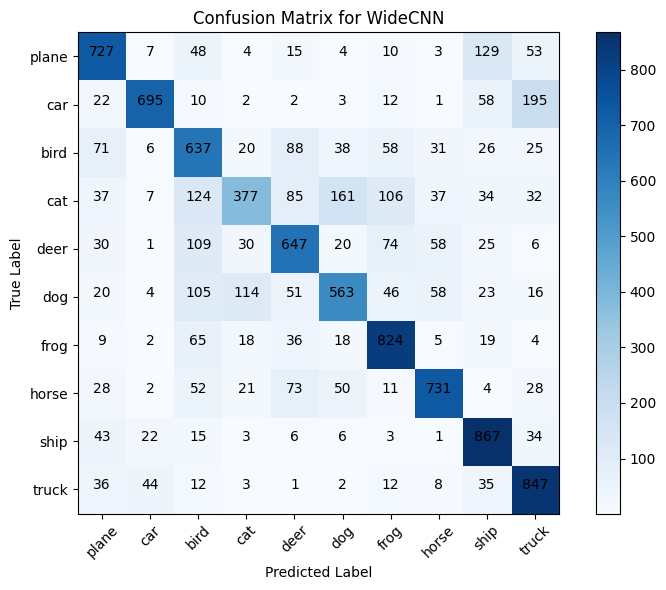

In [19]:
# see the confusion matrix
def plot_confusion_matrix(model, dataloader):
    model.eval()
    all_preds = torch.tensor([], dtype=torch.long)
    all_labels = torch.tensor([], dtype=torch.long)

    #get pred and true labels
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds = torch.cat((all_preds, preds), dim=0)
            all_labels = torch.cat((all_labels, labels), dim=0)

    # create compute confusion matrix
    cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())

    # Plot confusion matrix with matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.colorbar()

    #labels
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # add text inside boxes for actual values
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

#best models confusion matrix
plot_confusion_matrix(best_model, testloader)